In [2]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, mean_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_iris, load_boston
from sklearn.model_selection import train_test_split
from sklearn.externals.joblib import parallel_backend
from dask.distributed import Client
from sklearn.svm import LinearSVC
import pandas as pd
from tensorflow.keras.datasets import fashion_mnist

import joblib
import itertools
import warnings
import warnings

warnings.filterwarnings("ignore")

%matplotlib inline
%reload_ext nb_black

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
def plot_confusion_matrix(
    cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues
):

    plt.figure(figsize=(20, 10))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

<IPython.core.display.Javascript object>

## Dataset 1

In [3]:
iris = load_iris()
X = iris.data
y = iris.target

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Use an Ensemble of Models

In [5]:
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = LinearSVC(random_state=0, tol=1e-5, max_iter=200)

<IPython.core.display.Javascript object>

In [6]:
voting_clf = VotingClassifier(
    estimators=[("lr", log_clf), ("rf", rnd_clf), ("svc", svm_clf)], voting="hard"
)

# voting_clf.fit(X_train, y_train)

<IPython.core.display.Javascript object>

In [7]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 1.0
RandomForestClassifier 1.0
LinearSVC 1.0
VotingClassifier 1.0


<IPython.core.display.Javascript object>

## Dataset 2

In [5]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
x_train = x_train.reshape(60000, 28 * 28)
x_test = x_test.reshape(10000, 28 * 28)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
client = Client(processes=False)

<IPython.core.display.Javascript object>

In [11]:
with joblib.parallel_backend("dask"):

    for clf in (log_clf, rnd_clf, svm_clf, voting_clf):

        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)

        print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.8412
RandomForestClassifier 0.8754
LinearSVC 0.7993
VotingClassifier 0.8563


<IPython.core.display.Javascript object>

## Bagging

In [12]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    RandomForestClassifier(),
    n_estimators=10,
    max_samples=100,
    bootstrap=True,
    n_jobs=-1,
)

bag_clf.fit(x_train, y_train)

BaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=True,
                                                        ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features='auto',
                                                        max_leaf_nodes=None,
                                                        max_samples=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
     

<IPython.core.display.Javascript object>

In [13]:
y_pred = bag_clf.predict(x_test)

<IPython.core.display.Javascript object>

In [14]:
print(accuracy_score(y_test, y_pred))

0.7408


<IPython.core.display.Javascript object>

## Pasting

In [15]:
bag_clf = BaggingClassifier(
    RandomForestClassifier(),
    n_estimators=10,
    max_samples=100,
    bootstrap=False,  # False
    n_jobs=-1,
)

bag_clf.fit(x_train, y_train)

BaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=True,
                                                        ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features='auto',
                                                        max_leaf_nodes=None,
                                                        max_samples=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
     

<IPython.core.display.Javascript object>

In [16]:
y_pred = bag_clf.predict(x_test)
print(accuracy_score(y_test, y_pred))

0.735


<IPython.core.display.Javascript object>

#### Out of Bag Evaluation

In [17]:
bag_clf = BaggingClassifier(
    RandomForestClassifier(),
    n_estimators=10,
    max_samples=100,
    bootstrap=True,
    n_jobs=-1,
    oob_score=True,
)
bag_clf.fit(x_train, y_train)

BaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=True,
                                                        ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features='auto',
                                                        max_leaf_nodes=None,
                                                        max_samples=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
     

<IPython.core.display.Javascript object>

In [18]:
print("oob_score:", bag_clf.oob_score_)

y_pred = bag_clf.predict(x_test)
print("test accuracy:", accuracy_score(y_test, y_pred))

oob_score: 0.7512
test accuracy: 0.7397


<IPython.core.display.Javascript object>

## Random Forest

#### Classification

In [19]:
rnd_clf = RandomForestClassifier(n_estimators=100, max_leaf_nodes=16, n_jobs=-1)

rnd_clf.fit(x_train, y_train)

y_pred_rf = rnd_clf.predict(x_test)

<IPython.core.display.Javascript object>

In [20]:
print("Random forest accuracy score:", accuracy_score(y_test, y_pred))

Random forest accuracy score: 0.7397


<IPython.core.display.Javascript object>

#### Regression

In [7]:
x_reg, y_reg = load_boston(return_X_y=True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
x_reg_train, x_reg_test, y_reg_train, y_reg_test = train_test_split(
    x_reg, y_reg, test_size=0.2, random_state=42
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
rnd_reg = RandomForestRegressor(n_estimators=100, max_leaf_nodes=16, n_jobs=-1)

rnd_reg.fit(x_reg_train, y_reg_train)

y_pred_rf_reg = rnd_reg.predict(x_reg_test)

<IPython.core.display.Javascript object>

In [24]:
print("Random forest MAE:", mean_absolute_error(y_reg_test, y_pred_rf_reg))

Random forest MAE: 2.2129152890716917


<IPython.core.display.Javascript object>

### Feature Importance

In [59]:
df = pd.DataFrame(
    columns=load_boston().feature_names, data=[rnd_reg.feature_importances_],
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [60]:
df = df.sort_values(by=0, ascending=True, axis=1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

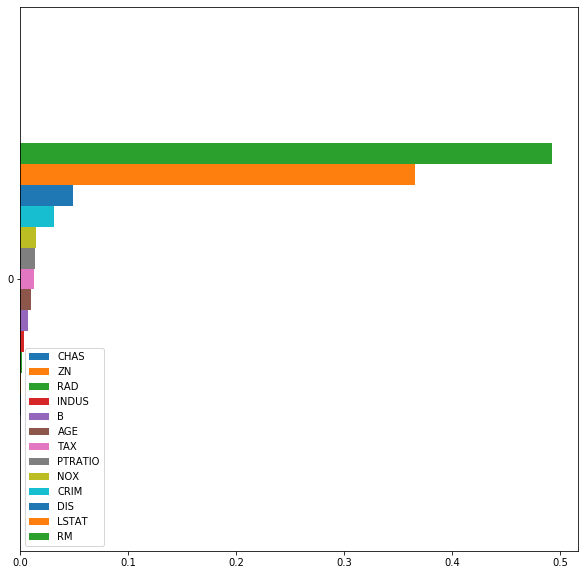

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [61]:
df.plot(kind="barh", figsize=(10, 10))

## Boosting

### Adaboost

In [67]:
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Classification

In [82]:
ada_clf = AdaBoostClassifier(n_estimators=100, algorithm="SAMME.R", learning_rate=0.5,)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [83]:
ada_clf.fit(x_train, y_train)

y_pred_adaboost = ada_clf.predict(x_test)

print("Adaboost accuracy score:", accuracy_score(y_test, y_pred_adaboost))

Adaboost accuracy score: 0.6302


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Gradient Boosting

In [77]:
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [80]:
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.5,)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [81]:
gb_clf.fit(x_train, y_train)

y_pred_gb = gb_clf.predict(x_test)

print("GradientBoosting accuracy score:", accuracy_score(y_test, y_pred_gb))

GradientBoosting accuracy score: 0.8749


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Regression

In [84]:
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=100, learning_rate=1.0)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [85]:
gbrt.fit(x_reg_train, y_reg_train)

y_pred_gbrt = gbrt.predict(x_reg_test)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [86]:
print("GradientBoosting MAE:", mean_absolute_error(y_reg_test, y_pred_gbrt))

GradientBoosting MAE: 2.376907334251308


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## XGBoost

In [10]:
from xgboost import XGBClassifier, XGBRegressor

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Classification

In [13]:
xgb_clf = XGBClassifier(n_estimators=100, learning_rate=0.5)

xgb_clf.fit(x_train, y_train)

y_pred_xgb = xgb_clf.predict(x_test)

print("XGBoostClassifier accuracy score:", accuracy_score(y_test, y_pred_xgb))

XGBoostClassifier accuracy score: 0.8979


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Regression

In [22]:
xgb_reg = XGBRegressor(n_estimators=10, learning_rate=0.5)

xgb_reg.fit(x_reg_train, y_reg_train)

y_pred_xgb_reg = xgb_reg.predict(x_reg_test)

print("XGBRegressor MAE:", mean_absolute_error(y_reg_test, y_pred_xgb_reg))

XGBRegressor MAE: 2.303574284385232


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>